In [1]:
import json
import pandas as pd
import numpy as np
from numpy import array

import torch
import torch.nn as nn
import torch.optim as optim

#from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon")

Mounted at /content/drive


In [3]:
#%run data_prep_10step_5horizon.ipynb
%run LSTM_Model_Classes.ipynb

In [4]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/data")
df_rf_15 = pd.read_csv('df_rf_15.csv')
df_rf_20 = pd.read_csv('df_rf_20.csv')
df_rf_25 = pd.read_csv('df_rf_25.csv')
df_rf_30 = pd.read_csv('df_rf_30.csv')
df_rf_35 = pd.read_csv('df_rf_35.csv')
df_rf_40 = pd.read_csv('df_rf_40.csv')
df_rf_45 = pd.read_csv('df_rf_45.csv')
df2_70 = pd.read_csv('df2_70.csv')
df2_70_remain = pd.read_csv('df2_70_remain.csv')
df2_allhero = pd.read_csv('df2_allhero.csv')
df2_all_remain = pd.read_csv('df2_all_remain.csv')
heroes= pd.read_csv('heroes.csv')
heroes = heroes.rename(columns={'id': 'hero_id'})

In [5]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/")
%run Useful_Functions.ipynb


In [6]:
def instantiate_model(df,hero_df,lookback,horizon,embed_dim):

    df = df
    lookback = lookback
    horizon = horizon
    embed_dim = embed_dim

    process_embedding = ProcessEmbedding(hero_df, embedding_dim=embed_dim, lookback=lookback) # we create the embedding vector on unsplit data to ensure all unique hero id's are contained

    input_size = process_embedding.embedding_dim + 1 #84 + 1
    hidden_size = 64
    num_layers = 2
    output_size = horizon  # Assuming you want to predict 5 values

    model = LSTMModel(input_size, hidden_size, num_layers, output_size, process_embedding)

    return model


def run_over_heroes(testing_df,hero_df,model, model_dict):

  # Create an empty dataframe to store the average RMSE scores for each hero
  df_results_all = pd.DataFrame(columns=['hero_id','match_id','rmse','unscaled_target','unscaled_pred'])

  # Get the unique hero_ids from the dataframe
  hero_ids = hero_df['hero_id'].unique()

  # Loop over each hero_id
  for hero_id in hero_ids:
      #print("Hero_ID: ", hero_id)
      # Filter the dataframe for the current hero_id
      testing_df_filtered = testing_df[testing_df['hero_id'] == hero_id]
      #hero_df = hero_df.iloc[:3] # Used to restrict how large the df is
      #print("Hero_df: ", hero_df)

      # Create empty lists to store the unscaled targets and predictions for the current hero
      #unscaled_targets_list = []
      #unscaled_preds_list = []

      # Loop over each record in the testing df for the current hero
      for index, row in testing_df_filtered.iterrows():
          # Extract the necessary information from the row
          match_id = row['match_id']
          #print("Hero ID: ", hero_id, "Index: ", index, "Match ID: ", match_id)
          time_series = np.array(json.loads(row['gold_t'])).astype('float32')
          # Use this if loading from data_prep notebook instead of csv : time_series = np.array(row['gold_t']).astype('float32')

          # Scale the time series using the same scaling function used during training
          scaled_time_series = ConstantMinMaxScaler(time_series, min_gold, max_gold)

          # Create windows from the scaled time series
          X, y = create_windows(scaled_time_series, lookback , horizon)

          # Create a batch with the selected time series
          batch = ((hero_id,), (X,), (y,))


          #Load our passed model
          model.load_state_dict(model_dict)

          # Set the model to evaluation mode
          model.eval()

          # Disable gradient computation
          with torch.no_grad():
              # Forward pass
              outputs = model(batch)

              # Get the predicted values
              predicted = outputs.squeeze().numpy()
              #print("Predicted: ", predicted)

          #print("Y: ", y)
          #print("Y[:-5]: ", y[:,-5:])
          #print("Predicted: ", predicted)
          # Unscaling values
          unscaled_target = ConstantUnScaler(y[:,-horizon:], min_gold, max_gold)
          unscaled_pred = ConstantUnScaler(predicted, min_gold, max_gold)

          # Append the last unscaled target and prediction to the respective lists
          #unscaled_targets_list.append(unscaled_target)
          #unscaled_preds_list.append(unscaled_pred)

      # Calculate the RMSE for the current hero

          #print("Unscaled Targets: ", unscaled_target,"\n Unscaled Targets Shape", unscaled_target.shape)
          #print("Unscaled Preds: ", unscaled_pred,"\n Unscaled Preds Shape", unscaled_pred.shape)

          if len(unscaled_target.shape) == 1:
              # Single-sample case
              rmse = np.sqrt(mean_squared_error(unscaled_target, unscaled_pred))
          else:
              # Multi-sample case
              rmse = np.sqrt(mean_squared_error(unscaled_target, unscaled_pred.reshape(unscaled_target.shape)))

          #rmse = np.sqrt(mean_squared_error(unscaled_target, unscaled_pred))
          #print('RMSE: ', rmse)
      # Create a dataframe for the current hero with RMSE value

          df_results_hero = pd.DataFrame({'hero_id': hero_id, 'match_id': match_id, 'rmse': rmse, 'unscaled_target': [unscaled_target], 'unscaled_pred':[unscaled_pred]})
          #print("DF Results Hero: ", df_results_hero)

      # Append the hero_id and RMSE to the df_results_all dataframe
          df_results_all = pd.concat([df_results_all, df_results_hero], ignore_index = True)

  def calculate_avg_rmse(row):
    return row['rmse'] / row['unscaled_pred'].size

  def get_size(row):
    return row['unscaled_pred'].size

  # Apply the calculate_avg_rmse function to each row of df_results_all
  df_results_all['avg_rmse'] = df_results_all.apply(calculate_avg_rmse, axis=1)
  df_results_all['no_of_predictions'] = df_results_all.apply(get_size, axis = 1)

  df_results_all_nots = df_results_all.drop(columns = ['unscaled_target','unscaled_pred'])

  return df_results_all_nots


def create_match_count_df(training_df,df_results_all_nots):

  # We Want training_df here since the point of this function is to create a df that shows us how many matches
  #     a hero was trained on to see if there was a connection between a lack of training and a high RMSE
  hero_match_count = pd.DataFrame(columns = ['hero_id','match_count'])

  for hero_id in heroes['hero_id'].unique():
    match_count = (training_df['hero_id'] == hero_id).sum()
    hero_count = pd.DataFrame({'hero_id': [hero_id],'match_count':[match_count]})

    hero_match_count = pd.concat([hero_match_count,hero_count], ignore_index=True)


  # Group our results dataframe from run_over_heroes(): by hero, generate the average RMSE for each hero
  df_hero_avg_rmse = df_results_all_nots.groupby('hero_id')['rmse'].agg('mean').reset_index()
  df_hero_avg_rmse.columns = ['hero_id', 'hero_avg_rmse']

  # Sort df_hero_avg_rmse by 'hero_avg_rmse' in ascending order to find best/worst heroes
  df_hero_avg_rmse = df_hero_avg_rmse.sort_values('hero_avg_rmse')
  df_hero_avg_rmse = pd.merge(df_hero_avg_rmse, hero_match_count, on='hero_id', how='left')
  df_hero_avg_rmse = pd.merge(df_hero_avg_rmse, heroes[['hero_id','localized_name']], on='hero_id', how='left')

  return df_hero_avg_rmse


# I want to make a ts plot for the hero with the smallest avg RMSE, and worst RMSE using their best predicted match and worst predicted match
# use df_results_all_nots order by RMSE ascending, select that match_id + hero at the top and bottom

def select_matches_for_single_ts_plot(df_results_all_nots):
  lowest_record = df_results_all_nots.sort_values(by='avg_rmse',ascending = True).iloc[0]
  highest_of_the_low = df_results_all_nots[df_results_all_nots['hero_id'] == lowest_record['hero_id']].sort_values(by = 'avg_rmse',ascending = False).iloc[0]

  highest_record = df_results_all_nots.sort_values(by='avg_rmse',ascending = True).iloc[-1]
  lowest_of_the_high = df_results_all_nots[df_results_all_nots['hero_id'] == highest_record['hero_id']].sort_values(by = 'avg_rmse',ascending = False).iloc[0]

  return lowest_record,highest_of_the_low,highest_record,lowest_of_the_high


def plot_single_ts(testing_df,record, lookback, horizon, file_name):
  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots")
  hero_id = record['hero_id']
  match_id = record['match_id']
  print(hero_id)
  print(match_id)
  time_series = np.array(json.loads((testing_df[(testing_df['match_id'] == match_id) & (testing_df['hero_id'] == hero_id)]['gold_t']).values[0])).astype('float32')

  scaled_time_series = ConstantMinMaxScaler(time_series, min_gold, max_gold)

  X, y = create_windows(scaled_time_series, lookback, horizon = horizon)


  # Create a batch with the selected time series
  batch = ((hero_id,), (X,), (y,))

  # Load our saved model state
  model.load_state_dict(model_dict)

  # Set the model to evaluation mode
  model.eval()

  # Disable gradient computation
  with torch.no_grad():
      # Forward pass
      outputs = model(batch)

      # Get the predicted values
      predicted = outputs.squeeze().numpy()


  #Unscaling values
  unscaled_targets = ConstantUnScaler(y[:,-horizon:], min_gold, max_gold)
  unscaled_preds = ConstantUnScaler(predicted, min_gold, max_gold)

  #print(time_series)
  print("X: ", X)
  print("y: ", y)
  #print("Unscaled_targets: ", unscaled_targets)
  #print("unscaled_preds: ",unscaled_preds)

  unscaled_preds_series = np.ones_like(time_series) * np.nan

  # create an array from the unscaled_preds array that contains the values from the first row and the last value of each subsequent row
  row_one = unscaled_preds[0,]

  if horizon == 1:
    unscaled_preds_series[lookback:len(time_series)] = unscaled_preds
  else:
    if len(unscaled_preds.shape) != 1:
      last_of_rest = unscaled_preds[1:,-1]
      #print("last_of_rest: ", last_of_rest)
      unscaled_preds_series[lookback:len(time_series)] =  np.concatenate((row_one, last_of_rest), axis=0)
    else:
      unscaled_preds_series[lookback:len(time_series)] =  row_one
    #print(last_of_rest)



  # Plot actual values
  plt.plot(time_series, label="Whole Timeseries")

  # Plot predicted values
  #plt.plot(unscaled_targets, c='g', label="Target Values")
  plt.plot(unscaled_preds_series, c = 'r', label = "Forecasting Predictions")

  plt.title(f"HeroID:{hero_id}, Game Length: {len(time_series)} Minutes, Lookback Window: {lookback}")

  # Add a label to the x-axis
  plt.xlabel('Timestep (Minute)')

  # Add a label to the y-axis
  plt.ylabel('Gold')
  plt.legend()
  plt.savefig(f'{file_name}_single_ts_plot.png')
  plt.show()
  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/")

def plot_scatter(df_hero_avg_rmse, lookback,horizon, embed_dim,file_name):
  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots")
  plt.figure(figsize=(12, 8))
  plt.scatter(df_hero_avg_rmse['match_count'], df_hero_avg_rmse['hero_avg_rmse'], alpha=0.7)

  for i, txt in enumerate(df_hero_avg_rmse['localized_name']):
      x = df_hero_avg_rmse['match_count'][i]
      y = df_hero_avg_rmse['hero_avg_rmse'][i]
      plt.annotate(txt, (x, y), fontsize=8, xytext=(5, 5), textcoords='offset points', ha='left', va='bottom')

  plt.xlabel('Match Count')
  plt.ylabel('Hero Average RMSE')
  plt.title(f'Hero Average RMSE Scores vs Match Count\nModel: {lookback}step_{horizon}horizon_RMSE_{embed_dim}')
  #plt.suptitle('Model 10step_5horizon_RMSE_84')
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f'{file_name}_scatter_plot.png')
  plt.show()
  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/")


def plot_hist(df_hero_avg_rmse,file_name):
  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots")
  plt.figure(figsize=(10, 6))
  plt.hist(df_hero_avg_rmse['hero_avg_rmse'], bins=20, edgecolor='black', alpha=0.7)
  plt.xlabel('Hero Average RMSE')
  plt.ylabel('Frequency')
  plt.title('Distribution of Hero Average RMSE Scores')
  plt.grid(True)
  plt.savefig(f'{file_name}_histogram.png')
  plt.show()
  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/")


In [7]:
# instantiate_model(df,lookback,horizon,embed_dim)

# run_over_heroes(df,df2_allhero)

# create_match_count_df(testing_df,df_results_all_nots)

# select_matches_for_single_ts_plot(df_results_all_nots)

# plot_single_ts(testing_df,record, lookback, horizon, model_dict)

# plot_scatter(df_hero_avg_rmse, lookback, embed_dim)

# plot_hist(df_hero_avg_rmse)

In [8]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/lstm")

model_dict_10_5_rmse_84 = torch.load('10step_5horizon_RMSE_84.pth') #done
model_dict_5_5_rmse_84 = torch.load('5step_5horizon_RMSE_84.pth') #error?
model_dict_10_5_rmse_8 = torch.load('10step_5horizon_RMSE_8.pth') #done
model_dict_5_5_rmse_8 = torch.load('5step_5horizon_RMSE_8.pth') #done

model_dict_10_1_rmse_8 = torch.load('10step_1horizon_RMSE_8.pth') #done

<ipython-input-5-dd666afa5f8f>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X = torch.tensor(X)


121
7611956203
X:  tensor([[0.0000, 0.0016, 0.0047, 0.0064, 0.0093, 0.0101, 0.0122, 0.0139, 0.0164,
         0.0183],
        [0.0016, 0.0047, 0.0064, 0.0093, 0.0101, 0.0122, 0.0139, 0.0164, 0.0183,
         0.0210],
        [0.0047, 0.0064, 0.0093, 0.0101, 0.0122, 0.0139, 0.0164, 0.0183, 0.0210,
         0.0219],
        [0.0064, 0.0093, 0.0101, 0.0122, 0.0139, 0.0164, 0.0183, 0.0210, 0.0219,
         0.0239],
        [0.0093, 0.0101, 0.0122, 0.0139, 0.0164, 0.0183, 0.0210, 0.0219, 0.0239,
         0.0259],
        [0.0101, 0.0122, 0.0139, 0.0164, 0.0183, 0.0210, 0.0219, 0.0239, 0.0259,
         0.0281],
        [0.0122, 0.0139, 0.0164, 0.0183, 0.0210, 0.0219, 0.0239, 0.0259, 0.0281,
         0.0304],
        [0.0139, 0.0164, 0.0183, 0.0210, 0.0219, 0.0239, 0.0259, 0.0281, 0.0304,
         0.0323],
        [0.0164, 0.0183, 0.0210, 0.0219, 0.0239, 0.0259, 0.0281, 0.0304, 0.0323,
         0.0332],
        [0.0183, 0.0210, 0.0219, 0.0239, 0.0259, 0.0281, 0.0304, 0.0323, 0.0332,
         

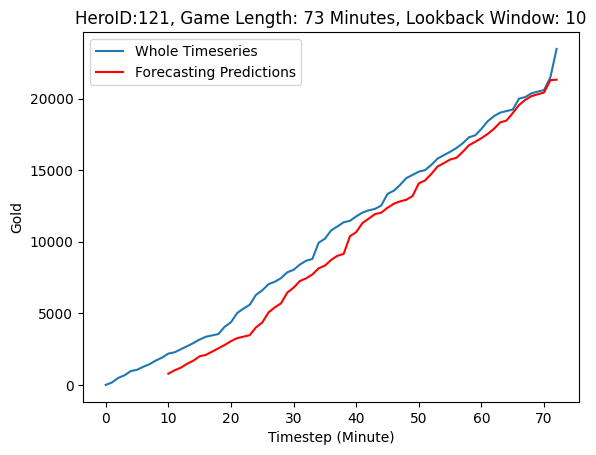

121
7628014111
X:  tensor([[0.0012, 0.0036, 0.0050, 0.0062, 0.0083, 0.0117, 0.0130, 0.0164, 0.0205,
         0.0246],
        [0.0036, 0.0050, 0.0062, 0.0083, 0.0117, 0.0130, 0.0164, 0.0205, 0.0246,
         0.0275],
        [0.0050, 0.0062, 0.0083, 0.0117, 0.0130, 0.0164, 0.0205, 0.0246, 0.0275,
         0.0298],
        [0.0062, 0.0083, 0.0117, 0.0130, 0.0164, 0.0205, 0.0246, 0.0275, 0.0298,
         0.0340],
        [0.0083, 0.0117, 0.0130, 0.0164, 0.0205, 0.0246, 0.0275, 0.0298, 0.0340,
         0.0376],
        [0.0117, 0.0130, 0.0164, 0.0205, 0.0246, 0.0275, 0.0298, 0.0340, 0.0376,
         0.0394],
        [0.0130, 0.0164, 0.0205, 0.0246, 0.0275, 0.0298, 0.0340, 0.0376, 0.0394,
         0.0445],
        [0.0164, 0.0205, 0.0246, 0.0275, 0.0298, 0.0340, 0.0376, 0.0394, 0.0445,
         0.0507],
        [0.0205, 0.0246, 0.0275, 0.0298, 0.0340, 0.0376, 0.0394, 0.0445, 0.0507,
         0.0546],
        [0.0246, 0.0275, 0.0298, 0.0340, 0.0376, 0.0394, 0.0445, 0.0507, 0.0546,
         

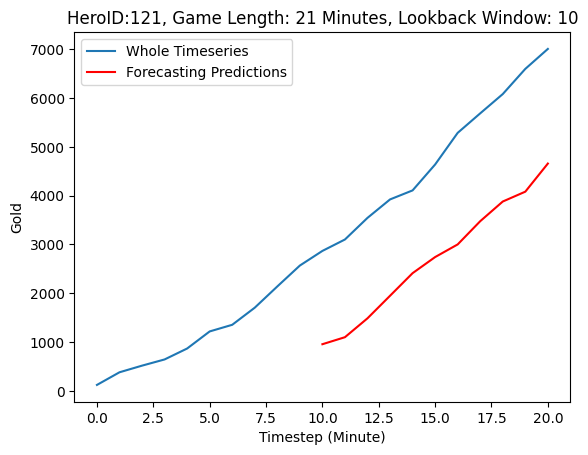

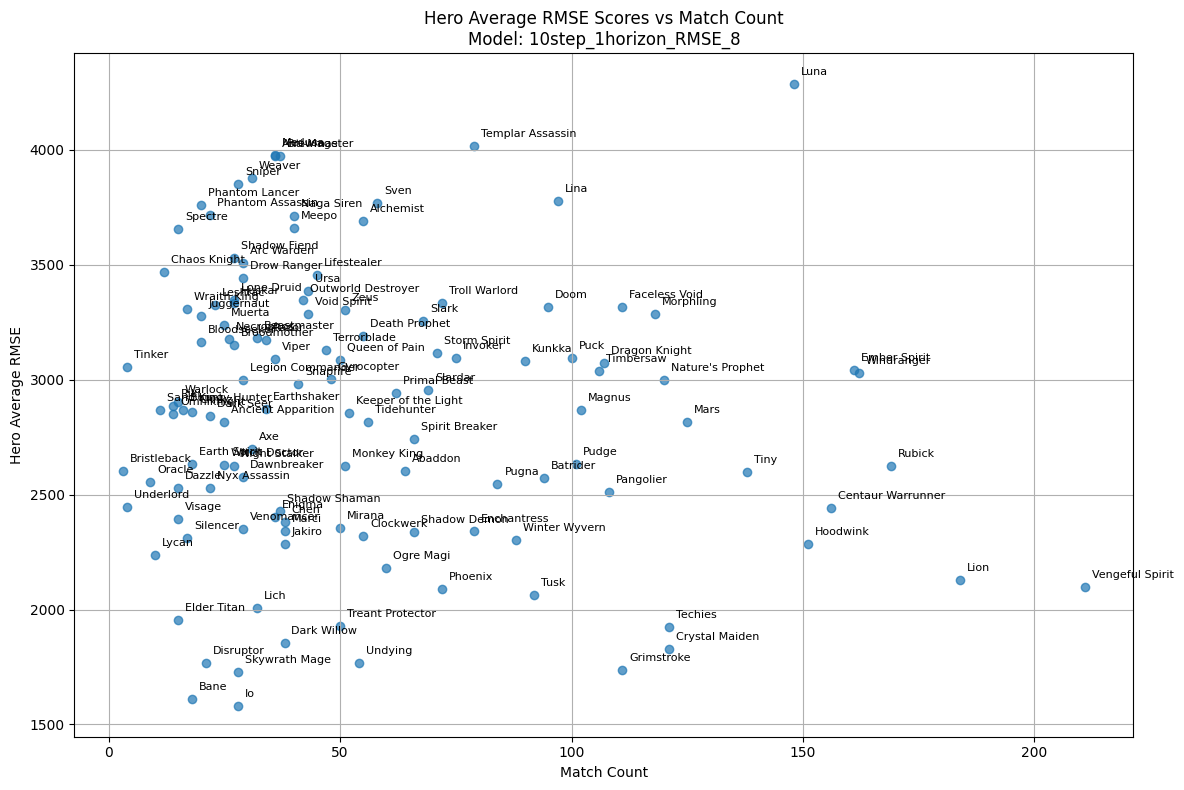

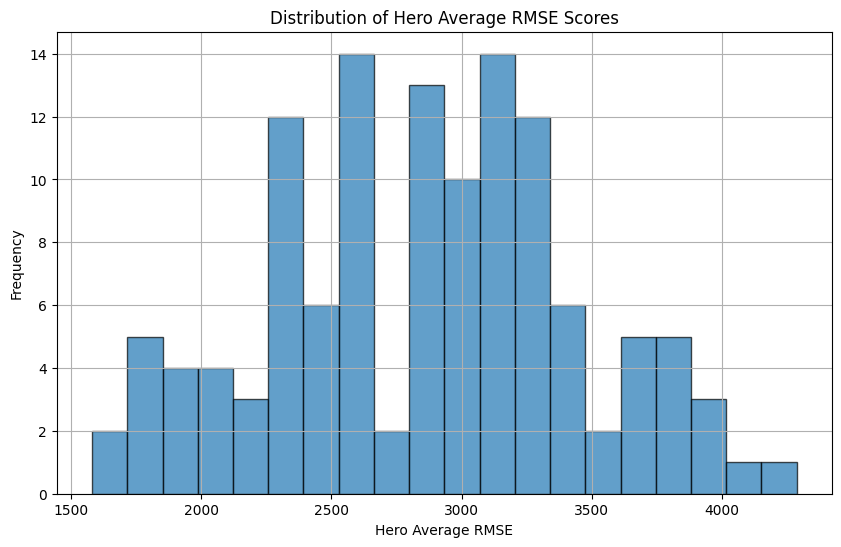

In [9]:
#10step_1Horizon_rmse_8
lookback = 10
horizon = 1
embed_dim = 8
model_dict = model_dict_10_1_rmse_8

model = instantiate_model(df = df2_70_remain,hero_df = df2_allhero,lookback=lookback,horizon=horizon,embed_dim=embed_dim) # returns model

df_results_all_nots = run_over_heroes(df2_70_remain,df2_allhero, model, model_dict)

match_count_rmse = create_match_count_df(df2_70,df_results_all_nots)

lowest_record,highest_of_the_low,highest_record,lowest_of_the_high = select_matches_for_single_ts_plot(df_results_all_nots)

file_name = '10_1_8_lowest_new'
plot_single_ts(df2_70_remain,lowest_record, lookback, horizon, file_name)
file_name = '10_1_8_hofl_new'
plot_single_ts(df2_70_remain,highest_of_the_low, lookback, horizon, file_name)

file_name = '10_1_8_new'
plot_scatter(match_count_rmse, lookback,horizon, embed_dim,file_name)

file_name = '10_1_8_new'
plot_hist(match_count_rmse,file_name)

20
7605460614


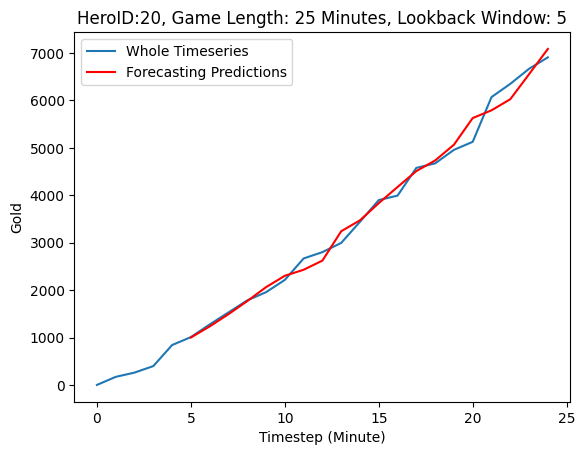

20
7625873218


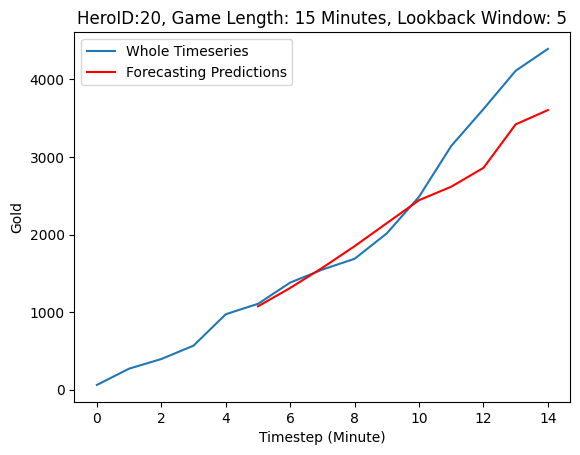

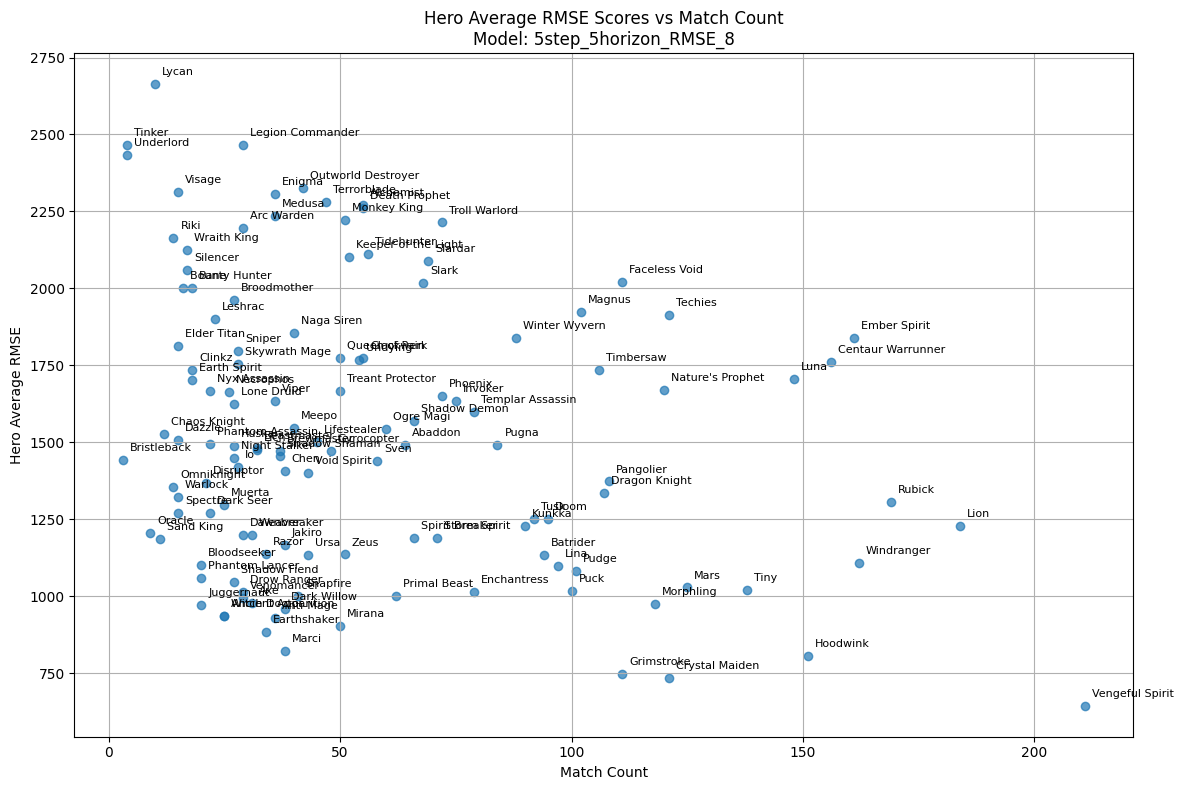

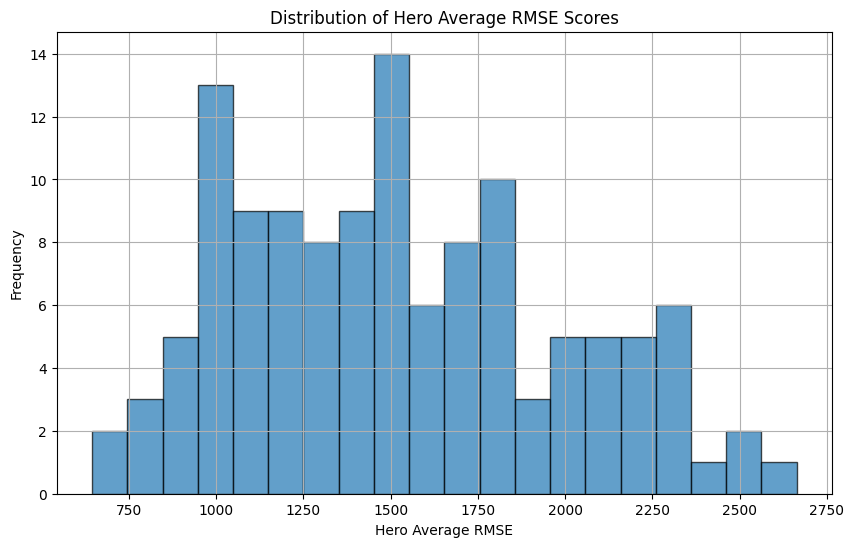

In [ ]:
#5step_5Horizon_rmse_8
lookback = 5
horizon = 5
embed_dim = 8
model_dict = model_dict_5_5_rmse_8


model = instantiate_model(df = df2_70_remain,hero_df = df2_allhero,lookback=lookback,horizon=horizon,embed_dim=embed_dim) # returns model

df_results_all_nots = run_over_heroes(df2_70_remain,df2_allhero, model, model_dict)

match_count_rmse = create_match_count_df(df2_70,df_results_all_nots)

lowest_record,highest_of_the_low,highest_record,lowest_of_the_high = select_matches_for_single_ts_plot(df_results_all_nots)

file_name = '5_5_8_lowest'
plot_single_ts(df2_70_remain,lowest_record, lookback, horizon, file_name)
file_name = '5_5_8_hofl'
plot_single_ts(df2_70_remain,highest_of_the_low, lookback, horizon, file_name)

file_name = '5_5_8_'
plot_scatter(match_count_rmse, lookback, embed_dim,file_name)

file_name = '5_5_8_'
plot_hist(match_count_rmse,file_name)

23
7610750910


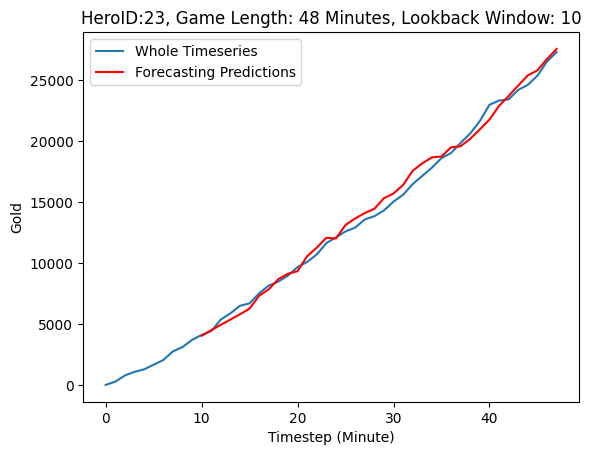

23
7625873218


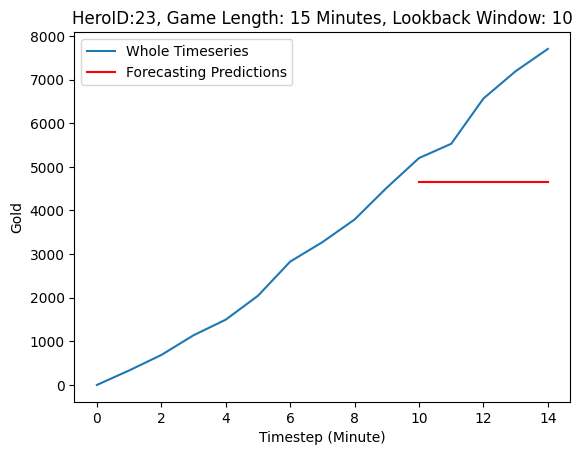

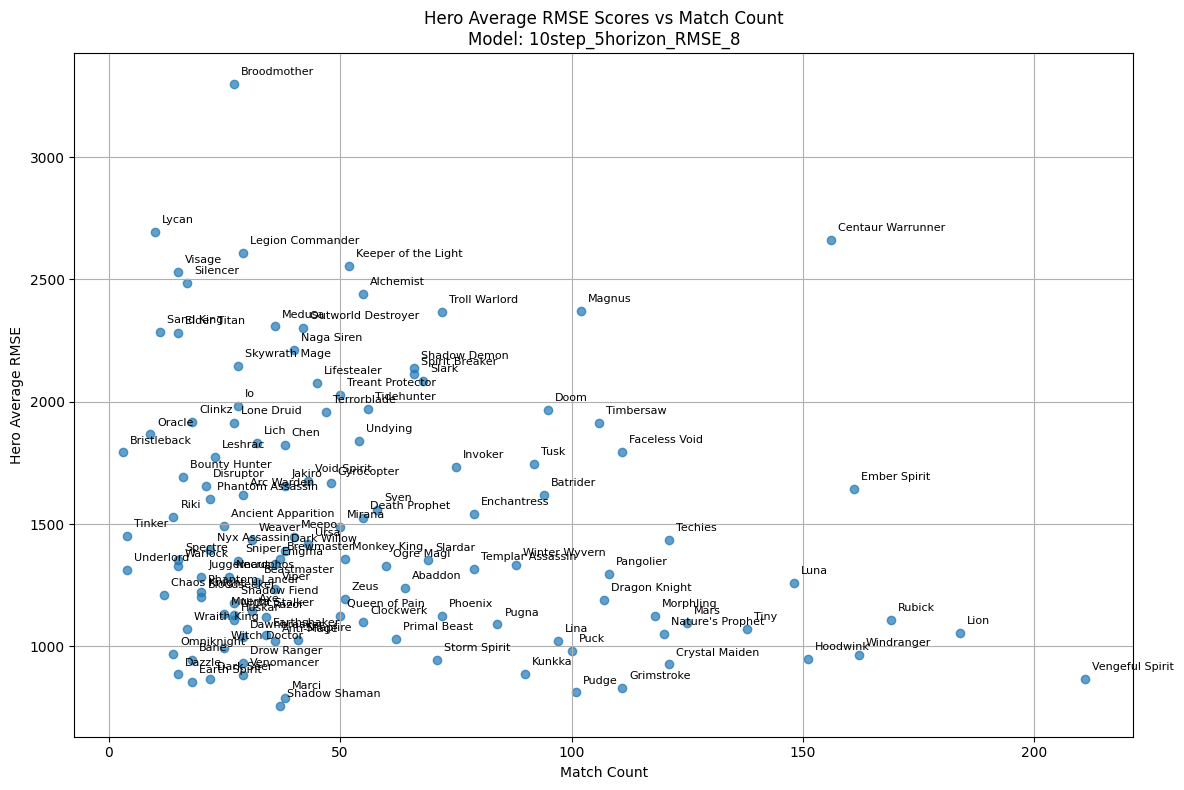

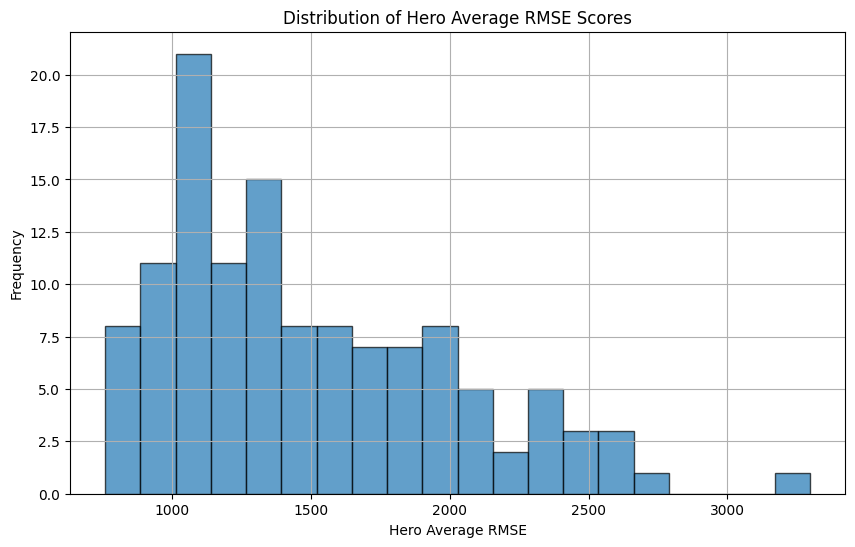

In [ ]:
#10step_5Horizon_rmse_8
lookback = 10
horizon = 1
embed_dim = 8
model_dict = model_dict_10_1_rmse_8


model = instantiate_model(df = df2_70_remain,hero_df = df2_allhero,lookback=lookback,horizon=horizon,embed_dim=embed_dim) # returns model

df_results_all_nots = run_over_heroes(df2_70_remain,df2_allhero, model, model_dict)

match_count_rmse = create_match_count_df(df2_70,df_results_all_nots)

lowest_record,highest_of_the_low,highest_record,lowest_of_the_high = select_matches_for_single_ts_plot(df_results_all_nots)

file_name = '10_5_8_lowest'
plot_single_ts(df2_70_remain,lowest_record, lookback, horizon, file_name)
file_name = '10_5_8_hofl'
plot_single_ts(df2_70_remain,highest_of_the_low, lookback, horizon, file_name)

file_name = '10_5_8_'
plot_scatter(match_count_rmse, lookback, embed_dim,file_name)

file_name = '10_5_8_'
plot_hist(match_count_rmse,file_name)

<ipython-input-5-dd666afa5f8f>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X = torch.tensor(X)


45
7606260002


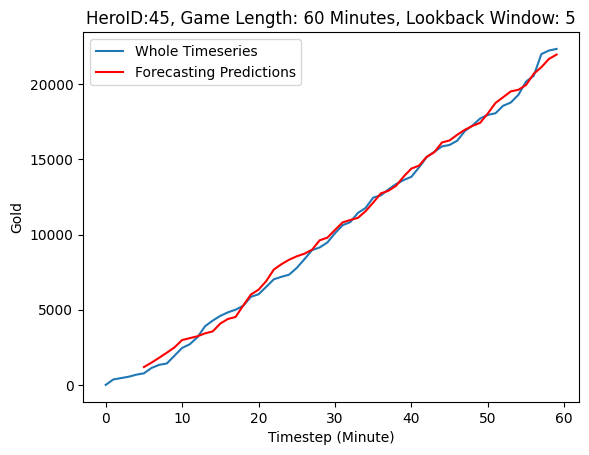

45
7618842515


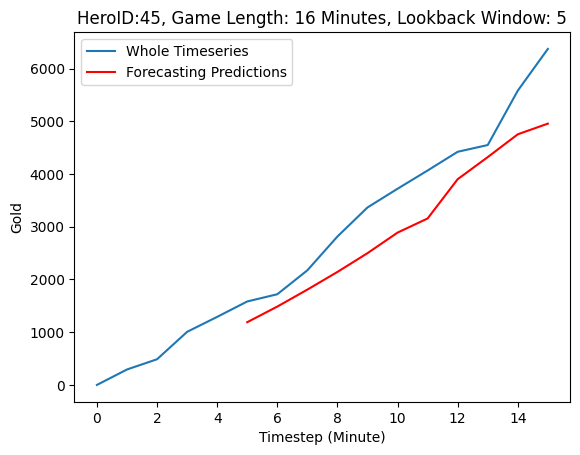

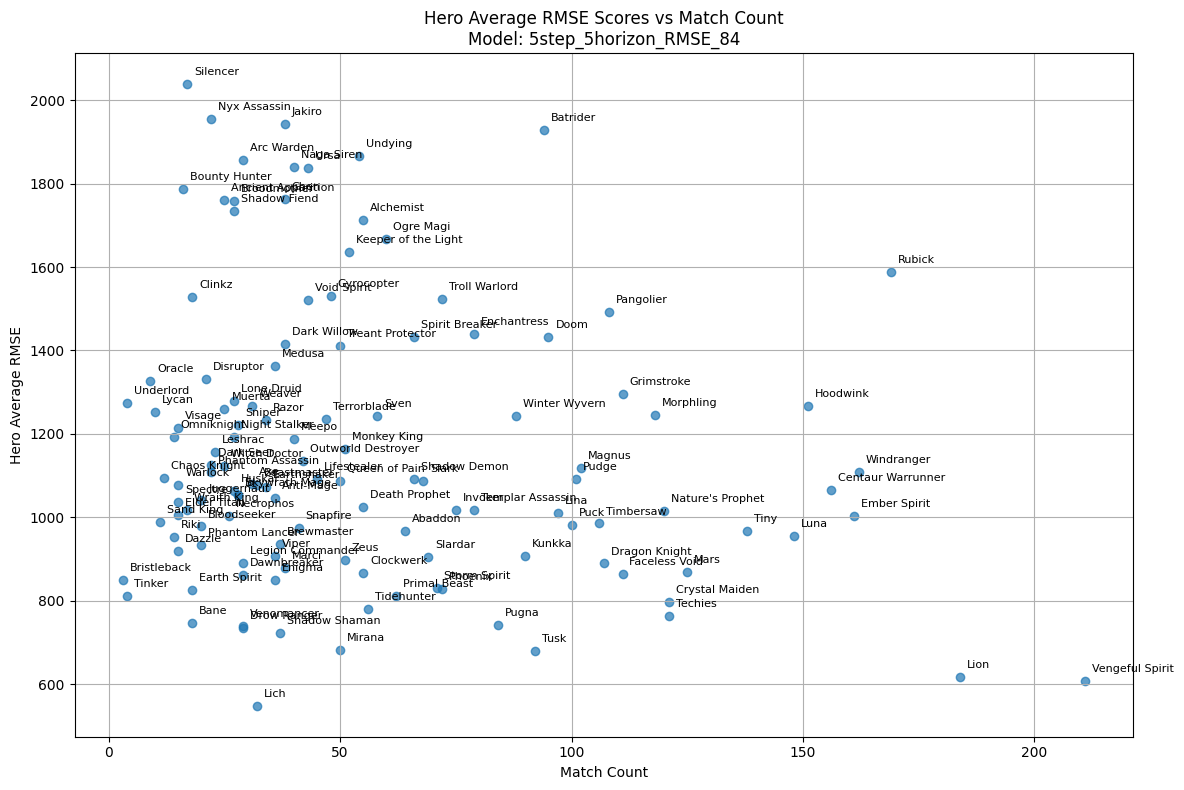

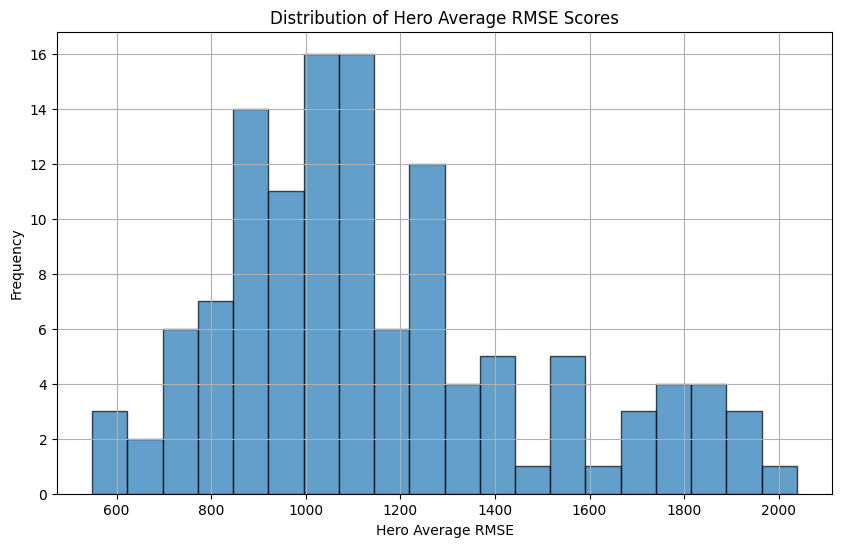

In [ ]:
#5step_5Horizon_rmse_84
lookback = 5
horizon = 5
embed_dim = 84
model_dict = model_dict_5_5_rmse_84


model = instantiate_model(df = df2_70_remain,hero_df = df2_allhero,lookback=lookback,horizon=horizon,embed_dim=embed_dim) # returns model

df_results_all_nots = run_over_heroes(df2_70_remain,df2_allhero, model, model_dict)

match_count_rmse = create_match_count_df(df2_70,df_results_all_nots)

lowest_record,highest_of_the_low,highest_record,lowest_of_the_high = select_matches_for_single_ts_plot(df_results_all_nots)

file_name = '5_5_84_lowest'
plot_single_ts(df2_70_remain,lowest_record, lookback, horizon, file_name)
file_name = '5_5_84_hofl'
plot_single_ts(df2_70_remain,highest_of_the_low, lookback, horizon, file_name)

file_name = '5_5_84_'
plot_scatter(match_count_rmse, lookback, embed_dim,file_name)

file_name = '5_5_84_'
plot_hist(match_count_rmse,file_name)

In [ ]:
df_results_all_nots.sort_values(by='rmse',ascending = True)


NameError: name 'df_results_all_nots' is not defined

,hero_id,match_count
0,1,36
1,2,31
2,3,18
3,4,20
4,5,121
...,...,...
119,135,29
120,136,38
121,137,62
122,138,25


,hero_id,hero_avg_rmse,match_count,localized_name
115,9,1419.678223,50,Mirana
116,4,1429.263062,20,Bloodseeker
117,42,1499.274292,17,Wraith King
118,18,1509.282715,58,Sven
119,6,1516.023682,29,Drow Ranger
120,114,1565.052246,51,Monkey King
121,1,1590.650269,36,Anti-Mage
122,10,1701.703735,118,Morphling
123,8,2098.434814,20,Juggernaut


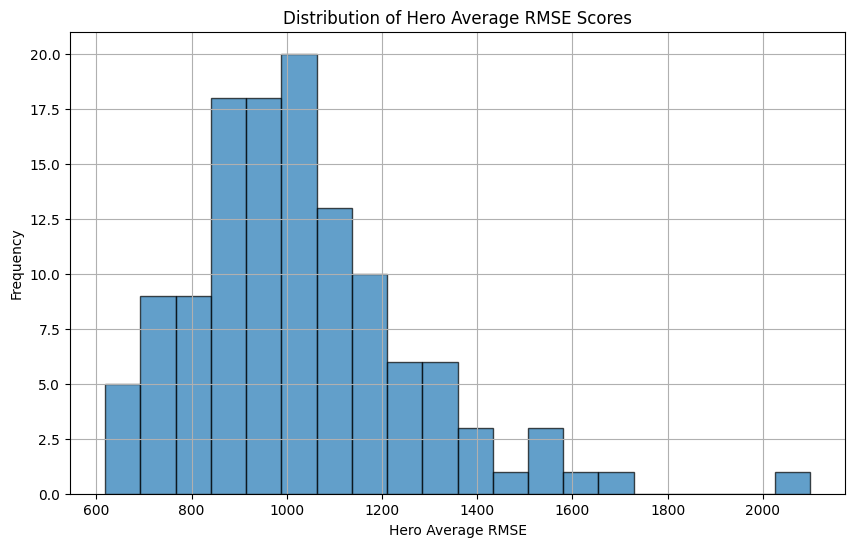

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_hero_avg_rmse['hero_avg_rmse'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Hero Average RMSE')
plt.ylabel('Frequency')
plt.title('Distribution of Hero Average RMSE Scores')
plt.grid(True)
plt.show()

In [ ]:
# Functions:

def single_hero_plot():

  index = 5  # Choose the index of the desired time series
  selected_row = df2_all_remain.iloc[index]

  # Extract the necessary information from the selected row
  hero_id = selected_row['hero_id']
  time_series = np.array(json.loads(selected_row['gold_t'])).astype('float32')

  # Scale the time series using the same scaling function used during training
  scaled_time_series = ConstantMinMaxScaler(time_series, min_gold, max_gold)

  # Create windows from the scaled time series
  X, y = create_windows(scaled_time_series, lookback, horizon = 5)


  # Create a batch with the selected time series
  batch = ((hero_id,), (X,), (y,))

  # Load our saved model state
  model.load_state_dict(model_dict)

  # Set the model to evaluation mode
  model.eval()

  # Disable gradient computation
  with torch.no_grad():
      # Forward pass
      outputs = model(batch)

      # Get the predicted values
      predicted = outputs.squeeze().numpy()


  #Unscaling values
  unscaled_targets = ConstantUnScaler(y[:,-5:], min_gold, max_gold)
  unscaled_preds = ConstantUnScaler(predicted, min_gold, max_gold)

  # Print the Time Series
  #print("Timeseries:")
  #print(time_series)
  # Print the predicted values
  #print("Targets:")
  #print(y[:,-5:])
  #print("Predicted values:")
  #print(predicted)

  # Print Unscaled Targets
  #print("Unscaled Targets")
  #print(unscaled_targets)
  #print("Unscaled Preds")
  #print(unscaled_preds)
